In [1]:
import os
import glob
import bz2
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# Specifying filename and directory
data_dir = os.getcwd() + '/data'
quotebank_dir = data_dir + "/Quotebank"
quotebank_bz2 = os.listdir(quotebank_dir)
print(quotebank_bz2)

# Change directory
os.chdir(quotebank_dir)

['.DS_Store', 'quotes-2020-movies.json.bz2', 'quotes-2015-movies.json.bz2', 'quotes-2017-movies.json.bz2', 'quotes-2018-movies.json.bz2', 'quotes-2016-movies.json.bz2', 'quotes-2019-movies.json.bz2']


In [3]:
df = pd.DataFrame()
for year_file in tqdm(quotebank_bz2):
    if year_file != '.DS_Store':
        temp =  pd.read_json(year_file, lines=True, compression='bz2')
        df = pd.concat([df, temp], ignore_index = True) 
df.shape

  0%|          | 0/7 [00:00<?, ?it/s]

(67736, 10)

In [4]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2020-02-04-010360,Birds of Prey has already been lauded for its ...,None,[],2020-02-04 16:17:42,1,"[[None, 0.9588], [Alex Ross, 0.0412]]",[https://nerdist.com/article/dc-birds-of-prey-...,E,Birds of Prey: And the Fantabulous Emancipatio...
1,2020-02-06-011469,Birds of Prey: The Fantabulous Emancipation of...,None,[],2020-02-06 09:35:03,2,"[[None, 0.872], [Jon Valera, 0.128]]",[https://www.nbcnews.com/news/asian-america/bi...,E,Birds of Prey: And the Fantabulous Emancipatio...
2,2020-02-28-090827,"with the short and said, `We'd like to go with...",None,[],2020-02-28 22:02:10,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,E,Onward
3,2020-01-10-009513,Birds of Prey: The Album.,None,[],2020-01-10 13:54:31,57,"[[None, 0.6859], [Jurnee Smollett-Bell, 0.0772...",[https://www.aceshowbiz.com/news/view/00147273...,E,Birds of Prey: And the Fantabulous Emancipatio...
4,2020-02-19-090077,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19 20:30:15,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,E,Onward


Removing NaN-values. We see that these only occur in the `movie` attribute which right now is due to an issue in the data filtering. 

In [5]:
df.isnull().any()

quoteID           False
quotation         False
speaker           False
qids              False
date              False
numOccurrences    False
probas            False
urls              False
phase             False
movie             False
dtype: bool

In [6]:
df = df.loc[-df.isnull().any(axis=1)]

In [7]:
df.shape

(67736, 10)

### Dealing with the speakers

We investigate how many quotes does not have an obvious speaker and is denoted by 'None'. Turns out that it is approximately 38%.

In [8]:
number_none_speakers = len(df[df.speaker == 'None'])

print(f"'None'-speakers: {number_none_speakers}")
print(f"Total fraction of 'None'-speakers: {number_none_speakers / len(df)}")

'None'-speakers: 25588
Total fraction of 'None'-speakers: 0.37776071808196526


Even though the single speakers are not really important for answering our research questions, we choose to clean the data by chaning 'None'-speakers to the speaker with second highest probability from the `df.probas` attribute. 
<span style="color:red"> *TODO*: THIS MIGHT NEED RE-ENGENEERING TO A MORE EXCLUSIVE THING. right now trump gets assigned to a lot. </span>

In [9]:
# Removes speaker as being None to being the second most likely in case speaker is 'None'
proba_threshhold = 0.15

secondary_speaker = [df['probas'][i][1][0] if (speaker == 'None') and (float(df['probas'][i][1][1]) > proba_threshhold) else speaker for i, speaker in enumerate(tqdm(df['speaker']))]
df['speaker'] = secondary_speaker

  0%|          | 0/67736 [00:00<?, ?it/s]

In [10]:
number_none_speakers = len(df[df.speaker == 'None'])

print(f"'None'-speakers: {number_none_speakers}")
print(f"Total fraction of 'None'-speakers: {number_none_speakers / len(df)}")

'None'-speakers: 10121
Total fraction of 'None'-speakers: 0.14941832998700838


In [11]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2020-02-04-010360,Birds of Prey has already been lauded for its ...,None,[],2020-02-04 16:17:42,1,"[[None, 0.9588], [Alex Ross, 0.0412]]",[https://nerdist.com/article/dc-birds-of-prey-...,E,Birds of Prey: And the Fantabulous Emancipatio...
1,2020-02-06-011469,Birds of Prey: The Fantabulous Emancipation of...,None,[],2020-02-06 09:35:03,2,"[[None, 0.872], [Jon Valera, 0.128]]",[https://www.nbcnews.com/news/asian-america/bi...,E,Birds of Prey: And the Fantabulous Emancipatio...
2,2020-02-28-090827,"with the short and said, `We'd like to go with...",Al Jean,[],2020-02-28 22:02:10,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,E,Onward
3,2020-01-10-009513,Birds of Prey: The Album.,None,[],2020-01-10 13:54:31,57,"[[None, 0.6859], [Jurnee Smollett-Bell, 0.0772...",[https://www.aceshowbiz.com/news/view/00147273...,E,Birds of Prey: And the Fantabulous Emancipatio...
4,2020-02-19-090077,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19 20:30:15,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,E,Onward


Furthermore, we realize that there is a super specific timestamp on the `date` attribute. Later on we will match daily box office sales with the Quotebank data, so we strip the timestamps from the specific time of the date and focus solely on the date.

In [12]:
# Remove last part of date from the quoteID date string to be able to have an average daily sentiment score
reduced_dates = [("-").join(date.split("-")[:3]) for date in tqdm(df.quoteID)]
df['date'] = reduced_dates

  0%|          | 0/67736 [00:00<?, ?it/s]

In [13]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2020-02-04-010360,Birds of Prey has already been lauded for its ...,None,[],2020-02-04,1,"[[None, 0.9588], [Alex Ross, 0.0412]]",[https://nerdist.com/article/dc-birds-of-prey-...,E,Birds of Prey: And the Fantabulous Emancipatio...
1,2020-02-06-011469,Birds of Prey: The Fantabulous Emancipation of...,None,[],2020-02-06,2,"[[None, 0.872], [Jon Valera, 0.128]]",[https://www.nbcnews.com/news/asian-america/bi...,E,Birds of Prey: And the Fantabulous Emancipatio...
2,2020-02-28-090827,"with the short and said, `We'd like to go with...",Al Jean,[],2020-02-28,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,E,Onward
3,2020-01-10-009513,Birds of Prey: The Album.,None,[],2020-01-10,57,"[[None, 0.6859], [Jurnee Smollett-Bell, 0.0772...",[https://www.aceshowbiz.com/news/view/00147273...,E,Birds of Prey: And the Fantabulous Emancipatio...
4,2020-02-19-090077,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,E,Onward


The attribute `phase` seem to mostly take the values 'E'. The investigation below shows that all of the entries are in fact 'E' so we decide to remove it from the dataframe. From the documentation of the data we also do not find it relevant for our case. Also we won't be using the `quoteID` attribute but instead the WikiData compatible `qids`.

In [14]:
np.unique(df.phase, return_counts=True)
df = df.drop(['phase', 'quoteID'], axis=1)

### Handling outliers in the numOccurrences

We want to check for outliers in the number of occurrences as it is the only numercal attribute left. By a first descriptive analysis of the variable we suspect something fishy as the maximum number is quite high. We note that there are no weird values on the other side as the minimum value of occurrences is 1.

In [15]:
df.numOccurrences.describe()

count    67736.000000
mean         8.763700
std        444.275087
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      58945.000000
Name: numOccurrences, dtype: float64

We also want to see if this seems unfeasible when looking at the plots. The boxplot reveals that there is a need to investigate outliers and the plot of the occurences reveal that the distribution seem to follow a strong power law. We will have to deal with outliers to get anything meaningful from the data.

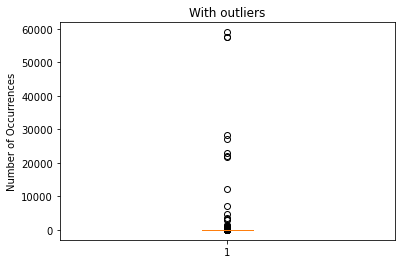

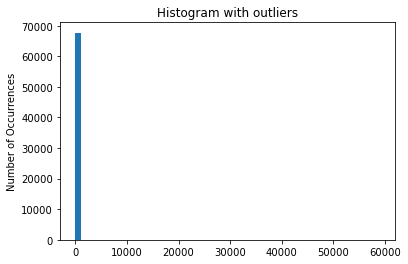

In [16]:
plt.boxplot(df.numOccurrences)
plt.ylabel("Number of Occurrences")
plt.title("With outliers")
plt.show()

plt.hist(df.numOccurrences, bins=50)
plt.ylabel("Number of Occurrences")
plt.title("Histogram with outliers")
plt.show()

As a start we will investigate whether the IQR outlier removal approach is feasible for our data. The code is taken and re-written from our homework 1 hand-in.


In [17]:
def get_outliers(data):
    """ Filters out outliers that is more than 1.5 times lower than the 25% quantile and above 1.5 times higher than the 
    75% quantile.
    
    Input is the sub-dataframe consisting of the columns assosiacted with kilometrage data.
    returns the indeces for rows that contains outliers.
    
    Function idea is taken from our implementation in Homework 1
    
    """
    
    series = pd.Series(data)
    
    IQR = (series.quantile(0.75) - series.quantile(0.25)) 
    outlier_threshold = IQR * 1.5

    # calculating decision boundaries
    lower = series.quantile(0.25)-outlier_threshold
    upper = series.quantile(0.75)+outlier_threshold

    # Finds the union of outlier indeces from the previous column and the current column
    outlier_indeces = np.union1d(series.index[series < lower], series.index[series > upper])

    return np.array([int(x) for x in outlier_indeces])

In [18]:
outlier_ids = get_outliers(df.numOccurrences)
print(f"Number of IQR outliers: {len(outlier_ids)}")
print(f"Ratio of IQR outliers in original data: {len(outlier_ids)/len(df)}")

Number of IQR outliers: 10679
Ratio of IQR outliers in original data: 0.15765619463800637


In [19]:
df = df.drop(outlier_ids)
df.index = np.arange(len(df))
df.shape

(57057, 8)

So 15% of the data was determined to be outliers based on the IQR range. We visualize the new distribution in the following. 

In [20]:
df.describe()

,numOccurrences
count,57057.000000
mean,1.365617
std,0.625762
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,3.000000


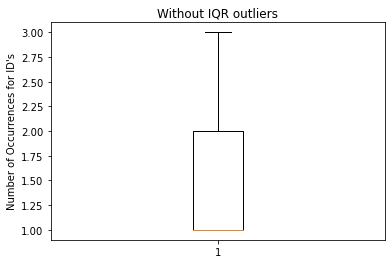

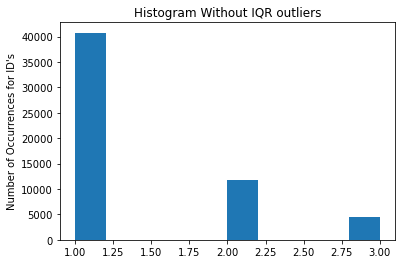

In [21]:
plt.boxplot(df.numOccurrences)
plt.ylabel("Number of Occurrences for ID's")
plt.title("Without IQR outliers")
plt.show()

plt.hist(df.numOccurrences)
plt.ylabel("Number of Occurrences for ID's")
plt.title("Histogram Without IQR outliers")
plt.show()

In [22]:
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
0,Birds of Prey has already been lauded for its ...,None,[],2020-02-04,1,"[[None, 0.9588], [Alex Ross, 0.0412]]",[https://nerdist.com/article/dc-birds-of-prey-...,Birds of Prey: And the Fantabulous Emancipatio...
1,Birds of Prey: The Fantabulous Emancipation of...,None,[],2020-02-06,2,"[[None, 0.872], [Jon Valera, 0.128]]",[https://www.nbcnews.com/news/asian-america/bi...,Birds of Prey: And the Fantabulous Emancipatio...
2,"with the short and said, `We'd like to go with...",Al Jean,[],2020-02-28,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,Onward
3,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,Onward
4,Sonic the Hedgehog might not become a kid-movi...,Brian Truitt,[],2020-02-14,1,"[[None, 0.7308], [Brian Truitt, 0.179], [Micha...",[http://www.gamespot.com/articles/sonic-the-he...,Sonic the Hedgehog


### Dealing with the quoter-IDs

Furthermore, we see that the `qids` might need some engineering. In the initial analyses on the 2019 NYT data we saw that some individuals are quoted differently even though it's in fact the same speaker. For instance this was the case for the speaker "Donald Trump" and "President Trump". In this case these two denotations share a common qID for which reason we would want to be able to get all quotes from Donald Trump and President Trump when searching for them independently. Even though it might not be as important with movies, we deem it good practice to regulate this behaviour. We start by engineering empty quoteID-lists as an unknown token.

In [23]:
empty = np.array([entry for entry, qID_list in enumerate(df.qids) if len(qID_list) == 0])
print(f"Number of currently unknown qids: {len(empty)}")

Number of currently unknown qids: 21461


In [24]:
pd.options.mode.chained_assignment = None
df['qids'][empty] = [['<UNK>']] * len(empty)

df.qids.head()

0      [<UNK>]
1      [<UNK>]
2      [<UNK>]
3    [Q164060]
4      [<UNK>]
Name: qids, dtype: object

Using this '\<UNK>' token we are able to search the df to replace this token with a qID if the speaker occurs with a qID another place in the data. In this manner all qIDs of a specified speaker will be the full list of qIDs associated with that speaker.

In [25]:
def set_qID(speaker, df):
    #Extract qID's of a speaker
    qIDs = {speaker: list({quote_ID for quote_IDlist in df.qids[df['speaker'] == speaker] for quote_ID in quote_IDlist})}
    
    # Conditions for removing the <UNK> token.
    if len(qIDs[speaker]) > 1 and '<UNK>' in qIDs[speaker]:
        qIDs[speaker].remove('<UNK>')
    
    # Creating new qIDs for replacing in original dataframe
    speaker_indeces = np.where(df.speaker == speaker)[0]
    replacement = pd.Series([qIDs[speaker]] * (sum(df['speaker'] == speaker)), index=speaker_indeces)
    
    # Replace
    df.qids[df['speaker'] == speaker] = replacement

This now works, which can be seen on the speaker George Lucas in the following cells.

In [26]:
df[df.speaker == 'George Lucas'].head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
472,"When I started to go into Star Wars, [ my frie...",George Lucas,"[Q1507803, Q38222]",2015-12-31,1,"[[George Lucas, 0.7612], [Colin Trevorrow, 0.1...",[http://theindianrepublic.com/i-sold-star-wars...,Star Wars: Episode VII - The Force Awakens
486,"After `Star Wars,' I went back to Warner Bros....",George Lucas,"[Q1507803, Q38222]",2015-04-19,1,"[[George Lucas, 0.6949], [None, 0.1538], [Step...",[http://sfgate.com/technology/businessinsider/...,Star Wars: Episode VII - The Force Awakens
509,a Star Wars for girls,George Lucas,[<UNK>],2015-01-27,1,"[[None, 0.5037], [George Lucas, 0.4963]]",[http://www.comicmix.com/2015/01/27/box-office...,Star Wars: Episode VII - The Force Awakens
523,We became friends and then we started dating a...,George Lucas,"[Q1507803, Q38222]",2015-12-19,2,"[[George Lucas, 0.5894], [None, 0.4106]]",[http://feeds.businessinsider.com.au/~/1290472...,Star Wars: Episode VII - The Force Awakens
540,I might use the lightsaber instead of a torch ...,George Lucas,[<UNK>],2015-10-30,2,"[[None, 0.8296], [George Lucas, 0.1704]]",[http://dailyliberal.com.au/story/3459543/movi...,Star Wars: Episode VII - The Force Awakens


In [27]:
# Calling the function
set_qID('George Lucas', df)

df[df.speaker == 'George Lucas'].head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
472,"When I started to go into Star Wars, [ my frie...",George Lucas,"[Q1507803, Q38222]",2015-12-31,1,"[[George Lucas, 0.7612], [Colin Trevorrow, 0.1...",[http://theindianrepublic.com/i-sold-star-wars...,Star Wars: Episode VII - The Force Awakens
486,"After `Star Wars,' I went back to Warner Bros....",George Lucas,"[Q1507803, Q38222]",2015-04-19,1,"[[George Lucas, 0.6949], [None, 0.1538], [Step...",[http://sfgate.com/technology/businessinsider/...,Star Wars: Episode VII - The Force Awakens
509,a Star Wars for girls,George Lucas,"[Q1507803, Q38222]",2015-01-27,1,"[[None, 0.5037], [George Lucas, 0.4963]]",[http://www.comicmix.com/2015/01/27/box-office...,Star Wars: Episode VII - The Force Awakens
523,We became friends and then we started dating a...,George Lucas,"[Q1507803, Q38222]",2015-12-19,2,"[[George Lucas, 0.5894], [None, 0.4106]]",[http://feeds.businessinsider.com.au/~/1290472...,Star Wars: Episode VII - The Force Awakens
540,I might use the lightsaber instead of a torch ...,George Lucas,"[Q1507803, Q38222]",2015-10-30,2,"[[None, 0.8296], [George Lucas, 0.1704]]",[http://dailyliberal.com.au/story/3459543/movi...,Star Wars: Episode VII - The Force Awakens


We want to apply this functionality to the full dataframe (meaning all individual speakers) for which reason we extract the individual speaker names and how frequently quoted they are. We calculate the number of unique quotes for each speaker even though we find it more relevant to do outlier detection based on total number of occurences (`numOccurrences` attribute). This will be done later in the pipeline.

In [28]:
speakers, freq_unsorted = np.unique(df.speaker, return_counts=True)
freq, speakers = np.array(list(zip(*sorted(zip(freq_unsorted, speakers), reverse=True))))

print("Top 10 quoted speakers (w/o numOccurences): ")
list(zip(speakers[:10], freq[:10]))

Top 10 quoted speakers (w/o numOccurences): 


[('None', '8351'),
 ('Kevin Feige', '1167'),
 ('Captain Marvel', '854'),
 ('Tom Holland', '550'),
 ('Joe Russo', '518'),
 ('J.J. Abrams', '514'),
 ('Bob Iger', '451'),
 ('Kathleen Kennedy', '437'),
 ('Rian Johnson', '432'),
 ('George Lucas', '377')]

In [29]:
for speaker in tqdm(speakers):
    set_qID(speaker, df=df)

  0%|          | 0/13650 [00:00<?, ?it/s]

Now, the only way there would be qID's of the name '\<UNK>' would be if the assignment of the predicted speaker is less than 15% percent certain (see `proba_threshhold` in the removal of None-type speakers) and if that same speaker does not have a qID throughout all of the dataframe. In this case we find evidence for deleting the rows.

In [30]:
UNK_idxs = np.array([], dtype=int)
for i, qID in enumerate(tqdm(df.qids)):
    if '<UNK>' in qID:
        UNK_idxs = np.append(UNK_idxs, i)

  0%|          | 0/57057 [00:00<?, ?it/s]

In [31]:
df = df.drop(UNK_idxs)
df.index = np.arange(len(df))
df.shape

(44970, 8)

The following function then concatenates the qID's of speakers if they have more than one qID in common, such that we get exactly the basis for a shared ID if two speakers (like Donald Trump and President Trump) are in fact the same.

In [32]:
def mergeQuoteIDs(df):
    qID_dict = defaultdict(dict)
    print("Creating qID dictionary...")
    for document_number, qid_list in enumerate(tqdm(df.qids)):
        for qid in qid_list:
            if qid in qID_dict:
                qID_dict[qid].append(document_number)
            else:
                qID_dict[qid] = [document_number]
    
    print("Gathering qIDs across documents...")
    new_column = {}
    for document_number, qid_list in enumerate(tqdm(df.qids)):
        document_IDs = []
        for qid in qid_list:
            document_IDs.append(qID_dict[qid])

        related_docs = set(np.concatenate(document_IDs))
        new_qids = list(set(np.concatenate(list(df.qids[related_docs]))))

        new_column[document_number] = new_qids

    df['qids'] = pd.Series(new_column)

In [33]:
mergeQuoteIDs(df)
df.head()

Creating qID dictionary...


  0%|          | 0/44970 [00:00<?, ?it/s]

Gathering qIDs across documents...


  0%|          | 0/44970 [00:00<?, ?it/s]

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
0,"with the short and said, `We'd like to go with...",Al Jean,[Q2829373],2020-02-28,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,Onward
1,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,Onward
2,Sonic the Hedgehog might not become a kid-movi...,Brian Truitt,[Q24387573],2020-02-14,1,"[[None, 0.7308], [Brian Truitt, 0.179], [Micha...",[http://www.gamespot.com/articles/sonic-the-he...,Sonic the Hedgehog
3,The animals do what he wants but operate in co...,Stephen Gaghan,[Q1971984],2020-01-24,1,"[[Stephen Gaghan, 0.7508], [None, 0.2492]]",[http://nst.com.my/lifestyle/groove/2020/01/55...,Dolittle
4,`Dolittle' is a more harmless and whimsical fa...,Robert Downey,[Q165219],2020-01-18,1,"[[Robert Downey, 0.6829], [None, 0.2553], [Kat...",[http://gulfnews.com/entertainment/hollywood/r...,Dolittle


And then we create a new ID for each unique list of qID's.

In [34]:
def newID(df):
    unique_IDlists = np.unique(df['qids'])
    newIDs = []
    
    for row_qIDlist in tqdm(df.qids):
        for newID, unique_list in enumerate(unique_IDlists):
            if unique_list == row_qIDlist:
                newIDs.append(newID)
    df['shared_ID'] = newIDs
    
    return newIDs

In [35]:
newIDs = newID(df)

  0%|          | 0/44970 [00:00<?, ?it/s]

In [36]:
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID
0,"with the short and said, `We'd like to go with...",Al Jean,[Q2829373],2020-02-28,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,Onward,3832
1,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,Onward,1151
2,Sonic the Hedgehog might not become a kid-movi...,Brian Truitt,[Q24387573],2020-02-14,1,"[[None, 0.7308], [Brian Truitt, 0.179], [Micha...",[http://www.gamespot.com/articles/sonic-the-he...,Sonic the Hedgehog,3155
3,The animals do what he wants but operate in co...,Stephen Gaghan,[Q1971984],2020-01-24,1,"[[Stephen Gaghan, 0.7508], [None, 0.2492]]",[http://nst.com.my/lifestyle/groove/2020/01/55...,Dolittle,2035
4,`Dolittle' is a more harmless and whimsical fa...,Robert Downey,[Q165219],2020-01-18,1,"[[Robert Downey, 0.6829], [None, 0.2553], [Kat...",[http://gulfnews.com/entertainment/hollywood/r...,Dolittle,1168


### Investigating the new ID's

We will now investigate how different ID's (the shared one) are distributed across quotes. We calculate the frequency with which ID is associated, meaning the total number of occurences for each ID.

In [37]:
print(f"Number of unique IDs: {np.max(df.shared_ID)}")

Number of unique IDs: 10253


In [38]:
freq_occurences = defaultdict(dict)

for ID in tqdm(newIDs):
    freq_occurences[ID] = sum(df[df['shared_ID'] == ID].numOccurrences)

  0%|          | 0/44970 [00:00<?, ?it/s]

In [39]:
freq_list = [(ID, count) for ID, count in sorted(freq_occurences.items(), key=lambda item: item[1], reverse=True)]
ID, freq = list(zip(*freq_list))
ID, freq = np.array(ID), np.array(freq)

Using a boxplot we also see that these ones seem to be full of outliers and by plotting the amount of occurrences with the speakers sorted in a descending manner, we see that the distribution looks like a strong power law.

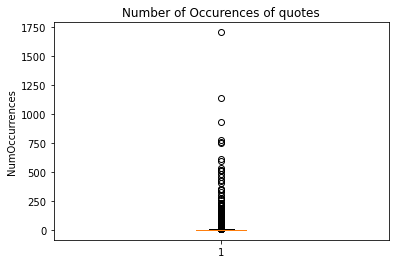

In [40]:
plt.boxplot(freq)
plt.ylabel("NumOccurrences")
plt.title('Number of Occurences of quotes')
plt.show()

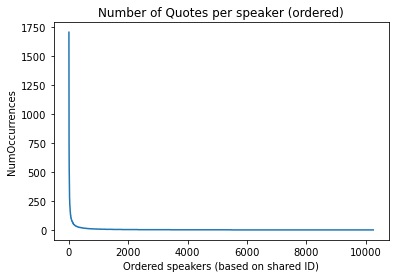

In [41]:
plt.plot(np.arange(len(freq)), freq)
plt.xlabel("Ordered speakers (based on shared ID)")
plt.ylabel("NumOccurrences")
plt.title('Number of Quotes per speaker (ordered)')
plt.show()

We do not regard this as a problem, since it seems reasonable that this depicts the real-world scenario where some people - like star directors and movie stars - have more to say than actors that are not playing in movies at the current time but still gets quoted once in a while.

By looking at the shared_ID, we now see that the ambiguity of speakers is now reduced - which will be useful in further analyses - as the new `shared_ID` attribute captures identical speaker denoted by different names.

In [42]:
N = 25
topN = []

print(f"Most quoted ID's: \n (shared_ID, total numOccurrences, associated speakers)\n")
for n in range(N):
    
    idxs = [i for (i, shared) in enumerate(df.shared_ID) if shared == ID[n]]
    associated_speakers = df.iloc[idxs, :].speaker.unique()
    
    info_tuple = (ID[n], freq[n], list(associated_speakers))
    topN.append(info_tuple)
    
    print(f"{n+1}) {topN[n]}\n")

Most quoted ID's: 
 (shared_ID, total numOccurrences, associated speakers)

1) (6653, 1705, ['Kevin Feige', 'KEVIN FEIGE'])

2) (5282, 1138, ['Captain Marvel'])

3) (1807, 930, ['J.J. Abrams', 'JJ Abrams', 'J. J. Abrams', 'jj abrams', 'J J Abrams', 'J.J. ABRAMS'])

4) (5380, 777, ['Tom Holland', 'TOM HOLLAND'])

5) (3214, 755, ['Joe Russo', 'Joseph Russo', 'joe russo'])

6) (7057, 748, ['Bob Iger', 'Robert Iger', 'Robert A. Iger', 'BOB IGER'])

7) (8289, 614, ['Rian Johnson', 'RIAN JOHNSON'])

8) (2970, 593, ['Kathleen Kennedy'])

9) (5668, 539, ['Patty Jenkins', 'PATTY JENKINS', 'patty Jenkins'])

10) (1168, 518, ['Robert Downey', 'ROBERT DOWNEY JR. .', 'Robert Downey Jr. .'])

11) (1722, 517, ['Gal Gadot'])

12) (673, 509, ['George Lucas', 'GEORGE LUCAS'])

13) (2379, 487, ['Mark Hamill', 'MARK HAMILL'])

14) (1370, 456, ['John Boyega'])

15) (3031, 428, ['Taika Waititi', 'TAIKA WAITITI'])

16) (7198, 420, ['Chris Hemsworth', 'chris hemsworth', 'CHRIS HEMSWORTH'])

17) (1878, 409, ['

### Add sentiment of quotes

We use the `Afinn` sentiment lexicon for mapping a sentiment score to each quote in the preprocessed Quotebank data.

In [43]:
!pip install Afinn
from afinn import Afinn

In [44]:
afn = Afinn()
sentiments = [afn.score(quote) for quote in tqdm(df.quotation)]
df['sentiment'] = sentiments

  0%|          | 0/44970 [00:00<?, ?it/s]

And now we see the average, max, min, etc. of the attribute.

In [45]:
df.sentiment.describe()

count    44970.000000
mean         2.539827
std          5.528586
min        -45.000000
25%          0.000000
50%          1.000000
75%          5.000000
max         89.000000
Name: sentiment, dtype: float64

The dataframe is saved as a pickle and we investigate the sentiment further in the `sentiment.ipynb` file.

In [46]:
# Save loaded DataFrame as pickle for faster loading time in the future
df.to_pickle(rf"{data_dir}/Quotebank_wSentiment.pkl")
print(f"Dataframe was pickled and saved to directory:\n" + data_dir)

Dataframe was pickled and saved to directory:
/Users/Julian/Documents/Studium/WS21_22/ada-2021-project-f-jab/data


In [47]:
N = len(df)-1
topN = []

print(f"Most quoted ID's: \n (shared_ID, total numOccurrences, associated speakers)\n")
for n in range(N):
    
    idxs = [i for (i, shared) in enumerate(df.shared_ID) if shared == ID[n]]
    associated_speakers = df.iloc[idxs, :].speaker.unique()
    
    info_tuple = (ID[n], freq[n], list(associated_speakers))
    topN.append(info_tuple)
    
    print(f"{n+1}) {topN[n]}\n")

Most quoted ID's: 
 (shared_ID, total numOccurrences, associated speakers)

1) (6653, 1705, ['Kevin Feige', 'KEVIN FEIGE'])

2) (5282, 1138, ['Captain Marvel'])

3) (1807, 930, ['J.J. Abrams', 'JJ Abrams', 'J. J. Abrams', 'jj abrams', 'J J Abrams', 'J.J. ABRAMS'])

4) (5380, 777, ['Tom Holland', 'TOM HOLLAND'])

5) (3214, 755, ['Joe Russo', 'Joseph Russo', 'joe russo'])

6) (7057, 748, ['Bob Iger', 'Robert Iger', 'Robert A. Iger', 'BOB IGER'])

7) (8289, 614, ['Rian Johnson', 'RIAN JOHNSON'])

8) (2970, 593, ['Kathleen Kennedy'])

9) (5668, 539, ['Patty Jenkins', 'PATTY JENKINS', 'patty Jenkins'])

10) (1168, 518, ['Robert Downey', 'ROBERT DOWNEY JR. .', 'Robert Downey Jr. .'])

11) (1722, 517, ['Gal Gadot'])

12) (673, 509, ['George Lucas', 'GEORGE LUCAS'])

13) (2379, 487, ['Mark Hamill', 'MARK HAMILL'])

14) (1370, 456, ['John Boyega'])

15) (3031, 428, ['Taika Waititi', 'TAIKA WAITITI'])

16) (7198, 420, ['Chris Hemsworth', 'chris hemsworth', 'CHRIS HEMSWORTH'])

17) (1878, 409, ['

195) (5722, 42, ['Mamata Banerjee'])

196) (67, 41, ['Jeff Goldblum'])

197) (2158, 40, ['Richard Roeper'])

198) (6894, 40, ['David Sims'])

199) (8163, 40, ['Jason Ward'])

200) (9910, 40, ['Trevor Noah'])

201) (8378, 40, ['Jon Schnepp'])

202) (6077, 39, ['Ava Duvernay', 'Ava DuVernay'])

203) (145, 39, ['Clark Gregg'])

204) (254, 39, ['Josh Gad'])

205) (5385, 39, ['Matt Tolmach'])

206) (2347, 39, ['John Carpenter', 'JOHN CARPENTER'])

207) (3696, 39, ['Angie Han'])

208) (2761, 39, ['Amber Heard'])

209) (5535, 39, ['Werner Herzog', 'werner herzog'])

210) (8417, 38, ['Hillary Clinton', 'HILLARY CLINTON'])

211) (4175, 38, ['Jim Lee'])

212) (9966, 38, ['Charlize Theron'])

213) (3584, 38, ['Don Cheadle'])

214) (839, 38, ['Jude Law'])

215) (2811, 38, ['Josh Hawley'])

216) (3905, 37, ['Brian Lowry'])

217) (1913, 37, ['Danny Elfman'])

218) (7747, 37, ['Chris Taylor'])

219) (4558, 37, ['Mark Hughes'])

220) (507, 37, ['Jeph Loeb'])

221) (4878, 36, ['Billy Dee Williams'])

2

421) (2710, 20, ['Christopher Nolan'])

422) (2554, 20, ['John Oliver'])

423) (7842, 20, ['Kelly Thompson'])

424) (5887, 20, ['Seungwon Lee'])

425) (4456, 20, ['John Wick'])

426) (7436, 20, ['Marc Bernardin'])

427) (2374, 20, ['Oliver Blume'])

428) (3742, 20, ['Darren Franich'])

429) (3099, 20, ['Victoria Alonso'])

430) (4699, 20, ['Rana Daggubati'])

431) (7656, 20, ['Heather Nauert'])

432) (9443, 20, ['Rodney Rothman'])

433) (3541, 20, ['Aaron Contreras'])

434) (7980, 19, ['Glen Weldon'])

435) (4179, 19, ['Roger Moore'])

436) (4831, 19, ['Ty Burr'])

437) (1813, 19, ['Thom Yorke'])

438) (5926, 19, ['Amod Mehra'])

439) (2663, 19, ['William Bibbiani'])

440) (2116, 19, ['Alicia Silverstone'])

441) (142, 19, ['John Knoll'])

442) (4249, 19, ['Jack Posobiec'])

443) (6101, 19, ['Luc Besson', 'LUC BESSON'])

444) (8966, 19, ['Liu Kang'])

445) (4842, 19, ['Raveesh Kumar'])

446) (10089, 19, ['Frank Grillo', 'FRANK GRILLO'])

447) (2774, 19, ['Keri Russell'])

448) (9067, 1

645) (8624, 13, ['Lawrence Sher'])

646) (7964, 13, ['Megan Thee Stallion'])

647) (2877, 12, ['Elisabeth Moss'])

648) (7056, 12, ['Nicholas Barber'])

649) (4541, 12, ['Veronica Roth'])

650) (5695, 12, ['Sir John'])

651) (4639, 12, ['Nina Jacobson'])

652) (9433, 12, ['Robin Hood'])

653) (10198, 12, ['Gerard Kennedy'])

654) (3185, 12, ['Bryan Young'])

655) (9147, 12, ['Paul Southern'])

656) (2476, 12, ['Paul Walker'])

657) (7884, 12, ['Adam Savage'])

658) (7228, 12, ['John Simon'])

659) (7462, 12, ['Ajay Bijli', 'AJAY Bijli'])

660) (4416, 12, ['Chiwetel Ejiofor'])

661) (8183, 12, ['William Shakespeare'])

662) (7808, 12, ['Marco Checchetto'])

663) (2130, 12, ['Cobie Smulders'])

664) (8550, 12, ['Kevin Tsujihara'])

665) (441, 12, ['Neal Adams'])

666) (3293, 12, ['Stephen Lane'])

667) (2262, 12, ['George W. Bush', 'Bush Jr. .', 'President Bush', 'President George W. Bush', 'President George H.W. Bush'])

668) (2310, 12, ['Frank Miller'])

669) (9255, 12, ['John Ostrande

870) (1157, 9, ['Lin-Manuel Miranda'])

871) (10095, 9, ['Daniel Salmon'])

872) (3769, 9, ['Geena Davis', 'GEENA DAVIS'])

873) (7071, 9, ['Eddie Cunningham'])

874) (4006, 9, ['Bobby Moynihan'])

875) (8607, 9, ['Major Nelson', 'Larry Hryb'])

876) (3572, 9, ['Pamela McClintock'])

877) (1948, 9, ['Alex Ross'])

878) (5702, 9, ['Kevin Conroy'])

879) (9083, 9, ['James Berardinelli'])

880) (2917, 9, ['Emilia Clarke'])

881) (6479, 9, ['Michael Olson'])

882) (9101, 9, ['Pat Fitzgerald'])

883) (8827, 9, ['Matt Wood', 'Matthew Wood'])

884) (2350, 9, ['Ram Bergman'])

885) (9310, 9, ['Rebecca Hall'])

886) (9494, 9, ['Ryan Blaney'])

887) (7377, 9, ['George Perez'])

888) (1784, 9, ['Todd Brown'])

889) (8132, 9, ['Jamie Martin'])

890) (3470, 9, ['Elaine Meyer'])

891) (1321, 9, ['Neal Scanlan'])

892) (9556, 9, ['Scott Barnes'])

893) (4331, 9, ['John Hughes'])

894) (22, 9, ['Halle Berry'])

895) (3703, 9, ['Gareb Shamus'])

896) (2161, 9, ['Chris Baker'])

897) (5381, 9, ['David D

1105) (10037, 7, ['Tim Johnson'])

1106) (875, 7, ['Doug Jones'])

1107) (4608, 7, ['Larry the Cable Guy', 'Larry The Cable Guy'])

1108) (620, 7, ['Emma Stone'])

1109) (7621, 7, ['Chris Paul'])

1110) (3102, 7, ['Devan Coggan'])

1111) (1217, 7, ['Stephen Galloway'])

1112) (2464, 7, ['Richard Smith'])

1113) (336, 7, ['Drew Karpyshyn'])

1114) (6561, 7, ['Chris Mayer'])

1115) (2614, 7, ['Carey Mulligan'])

1116) (180, 7, ['Dan Didio', 'Dan DiDio'])

1117) (1457, 7, ['Chad Richison'])

1118) (7360, 7, ['Cameron Boyce'])

1119) (8664, 7, ['Avi Lerner'])

1120) (5617, 7, ['Christian Louboutin'])

1121) (6096, 7, ['Dana Schwartz'])

1122) (8403, 7, ['Joseph Schooling'])

1123) (9811, 7, ['Thor Harris'])

1124) (3483, 7, ['James Mattis', 'Jim Mattis'])

1125) (9621, 7, ['Sharad Devarajan'])

1126) (4222, 7, ['Dave Dombrowski'])

1127) (7189, 7, ['Rick Heinrichs'])

1128) (9224, 7, ['Toby Kebbell'])

1129) (3, 7, ['Rahul Gandhi'])

1130) (2009, 7, ['Jim Lawson'])

1131) (7369, 7, ['Tana 

1333) (5589, 6, ['Michiko Kakutani'])

1334) (2450, 6, ['Teresa Delgado'])

1335) (4386, 6, ['Jason Reitman'])

1336) (1545, 6, ['Sanford Panitch'])

1337) (4257, 6, ['Doug Wead'])

1338) (5229, 6, ['James Hardin'])

1339) (1657, 6, ['Sofia Carson'])

1340) (1920, 6, ['Doug Armstrong'])

1341) (4197, 6, ['Xavier Woods'])

1342) (9820, 6, ['Tim Hanley'])

1343) (1927, 6, ['Sofia Coppola'])

1344) (4866, 6, ['Bruce Dern'])

1345) (4585, 6, ['Michael Wilkinson'])

1346) (8379, 6, ['Jon Snow'])

1347) (10025, 6, ['Milo Ventimiglia'])

1348) (242, 6, ['Joe Girardi'])

1349) (9965, 6, ['Will Shetterly'])

1350) (8158, 6, ['Jason Mantzoukas'])

1351) (1544, 6, ['John Millar'])

1352) (1703, 6, ['Ray Lampe'])

1353) (4633, 6, ['Jeremy Thorpe'])

1354) (7897, 6, ['Torsten Neubert'])

1355) (9064, 6, ['Lim Guan Eng'])

1356) (2030, 6, ['Al Gore'])

1357) (8898, 6, ['Michael Myers'])

1358) (4637, 6, ['Sadiq Khan'])

1359) (5837, 6, ['J. Han'])

1360) (2793, 6, ['Lucas Bjerregaard'])

1361) (2395

1564) (7572, 5, ['Tyler Durden'])

1565) (4103, 5, ['Terrence Howard'])

1566) (8890, 5, ['Michael Jackson'])

1567) (4821, 5, ['Brad Pitt'])

1568) (7252, 5, ['Frank Scheck'])

1569) (6102, 5, ['Neil Patrick Harris'])

1570) (3579, 5, ['Mike Avila'])

1571) (7020, 5, ['Temuera Morrison'])

1572) (8580, 5, ['Kyle Anderson'])

1573) (1218, 5, ['Gina Rodriguez'])

1574) (4329, 5, ['Tyrese Gibson'])

1575) (576, 5, ['Pharrell Williams'])

1576) (1971, 5, ['Ben Pearson'])

1577) (304, 5, ['Mr. Martin'])

1578) (4435, 5, ['Jimmy Vee'])

1579) (3119, 5, ['Shonda Rhimes'])

1580) (7913, 5, ['Daniel Bruhl', 'Daniel Brühl'])

1581) (5593, 5, ['Anna Faris'])

1582) (1666, 5, ['Newt Gingrich'])

1583) (846, 5, ['Gordon Hayward'])

1584) (4981, 5, ['Aziz Ansari'])

1585) (2953, 5, ['Carlos Santana'])

1586) (3162, 5, ['Joseph Kosinski'])

1587) (3936, 5, ['George Thorogood'])

1588) (3368, 5, ['Millie Bobby Brown'])

1589) (6380, 5, ['John Magufuli'])

1590) (3400, 5, ['Adrianne Palicki'])

1591) 

1792) (3973, 4, ['Benjamin Smith', 'Ben Smith'])

1793) (5160, 4, ['Colin Taylor'])

1794) (8949, 4, ['Mike Nichols'])

1795) (6951, 4, ['Derek Malcolm'])

1796) (3761, 4, ['Scott Nicholson'])

1797) (83, 4, ['Pastor Chris'])

1798) (4408, 4, ['Sam Rockwell', 'SAM ROCKWELL'])

1799) (6721, 4, ['Leila de Lima'])

1800) (2854, 4, ['Jørgen Vig Knudstorp'])

1801) (1829, 4, ['THOMAS JANE'])

1802) (2535, 4, ['CM Punk'])

1803) (4650, 4, ['Devin Townsend'])

1804) (5909, 4, ['Marc Schneider'])

1805) (1660, 4, ['Carol Robertson'])

1806) (4457, 4, ['John William'])

1807) (8252, 4, ['James Gray'])

1808) (9774, 4, ['Ted Baehr'])

1809) (10186, 4, ['James Luceno'])

1810) (995, 4, ['Sam Faiers'])

1811) (5965, 4, ['Andrew Leung'])

1812) (4695, 4, ['Justin Bieber'])

1813) (1348, 4, ['Aaron Task'])

1814) (7235, 4, ['Benjamin Baldwin'])

1815) (4390, 4, ['Ian Snell'])

1816) (5219, 4, ['Sylvester Stallone'])

1817) (4612, 4, ['Didier Lupfer'])

1818) (6306, 4, ['Brian Fox'])

1819) (531, 4, 

2022) (861, 4, ['Peter Lock'])

2023) (3953, 4, ['John Ramirez'])

2024) (6501, 4, ['Rarriwuy Hick'])

2025) (484, 4, ['Beth Revis'])

2026) (9299, 4, ['Randy Evans'])

2027) (3848, 4, ['Allan Heinberg'])

2028) (792, 4, ['Noah Syndergaard'])

2029) (5193, 4, ['Ryan Kalil'])

2030) (3566, 4, ['Grant Nicholas'])

2031) (9288, 4, ['Rajiv Chilaka'])

2032) (2957, 4, ['Dan Callahan'])

2033) (6991, 4, ['Santiago Martinez'])

2034) (8583, 4, ['Kyle Shanahan'])

2035) (5322, 4, ['Pat Harris'])

2036) (4396, 4, ['Pushpa Kamal Dahal'])

2037) (2453, 4, ['Ian George'])

2038) (4078, 4, ['Ira Madison III'])

2039) (7321, 4, ['Gary Graff'])

2040) (5438, 4, ['Coleen Rooney'])

2041) (2490, 4, ['David Wood'])

2042) (4258, 4, ['Douglas Dick'])

2043) (1852, 4, ['Chris Stephens'])

2044) (5745, 4, ['Abelardo Morell'])

2045) (1555, 4, ['Robbie Daymond'])

2046) (2060, 4, ['Drew Daywalt'])

2047) (186, 4, ['Greg Capullo'])

2048) (6252, 4, ['Bob Stoops'])

2049) (6570, 4, ['Chris Rhinehart'])

2050)

2251) (2689, 4, ['Richard Robinson'])

2252) (4729, 4, ['Owen Paterson'])

2253) (10204, 4, ['Kerry Wood'])

2254) (7863, 4, ['Sydney Schanberg'])

2255) (9408, 4, ['Robert Gordon'])

2256) (2313, 4, ['Sean P.'])

2257) (1473, 4, ['Kate Clifford Larson'])

2258) (1944, 4, ['Paul Williams'])

2259) (9365, 4, ['Rick Famuyiwa'])

2260) (6635, 4, ['Mark Dayton'])

2261) (1755, 4, ['Terry Parker'])

2262) (9963, 4, ['Will Matthews'])

2263) (10219, 4, ['Sergio Sanchez'])

2264) (5507, 4, ['James Blair'])

2265) (4066, 4, ['Corey Taylor'])

2266) (2458, 4, ['Rudy Giuliani'])

2267) (6645, 4, ['Colin Furze'])

2268) (7161, 4, ['Gabby Barrett'])

2269) (7417, 4, ['Gladys Berejiklian'])

2270) (4556, 4, ['Mark Cerny'])

2271) (3948, 4, ['Robert Webb'])

2272) (7348, 4, ['Milton Jones'])

2273) (2900, 4, ['Regina King'])

2274) (7322, 4, ['Gary Gulman'])

2275) (3091, 4, ['Mark Rober'])

2276) (806, 4, ['Priyanka Chopra Jonas'])

2277) (417, 4, ['Yoshiyuki Tomino'])

2278) (3076, 4, ['Julie Taym

2485) (2211, 3, ['Bodega Bamz'])

2486) (6878, 3, ['David Mullich'])

2487) (4977, 3, ['Bryan Anger'])

2488) (2438, 3, ['Paul Duncan'])

2489) (4911, 3, ['Jimmy Choo'])

2490) (5460, 3, ['Bill Miller'])

2491) (6869, 3, ['David Kidwell'])

2492) (1600, 3, ['Lenny Kravitz'])

2493) (7384, 3, ['Michael Ford'])

2494) (8326, 3, ['John Howard'])

2495) (5645, 3, ['Wang Xu'])

2496) (2836, 3, ['Kate Mara'])

2497) (7328, 3, ['Gary Powell'])

2498) (9242, 3, ['Craig Brewer'])

2499) (5401, 3, ['James Morris'])

2500) (874, 3, ['Mike Thompson'])

2501) (2541, 3, ['Carrie Underwood'])

2502) (4517, 3, ['Chris Moyles'])

2503) (3686, 3, ['Kacey Musgraves'])

2504) (2238, 3, ['Bill Hume'])

2505) (3916, 3, ['William Street'])

2506) (7526, 3, ['Jonathan King'])

2507) (213, 3, ['David Lean'])

2508) (2213, 3, ['COLBY BOOTHMAN'])

2509) (8655, 3, ['Lisa Anderson'])

2510) (1899, 3, ['Miltos Yerolemou'])

2511) (9767, 3, ['Tan Kheng Hua'])

2512) (8900, 3, ['Mike Nash'])

2513) (9785, 3, ['Johann


2716) (2983, 3, ['Ollie Horgan'])

2717) (7533, 3, ['Stephen Jones'])

2718) (3309, 3, ['Joely Fisher'])

2719) (6631, 3, ['Clark Kent'])

2720) (8638, 3, ['Lee Steele'])

2721) (4029, 3, ['Brett Johnson'])

2722) (9888, 3, ['Tony Black'])

2723) (4194, 3, ['Ryan Williams'])

2724) (5384, 3, ['Hallie Meyers-Shyer'])

2725) (9997, 3, ['DJ Khaled'])

2726) (5025, 3, ['Carol V. Ward'])

2727) (8295, 3, ['Gov. John Bel Edwards'])

2728) (3221, 3, ['Ben Mezrich'])

2729) (7916, 3, ['Andrea Kay'])

2730) (4168, 3, ['Philip McCann'])

2731) (4525, 3, ['Lorraine Kelly'])

2732) (8559, 3, ['Kim Thompson'])

2733) (9572, 3, ['Scott Pruitt'])

2734) (3635, 3, ["`` The Fox ''"])

2735) (9907, 3, ['Travis Kelce'])

2736) (5232, 3, ['Tom Price', 'Thomas Price'])

2737) (2538, 3, ['Jerry Seinfeld'])

2738) (2855, 3, ['Diego Valeri'])

2739) (10253, 3, ['Paul Nicholls'])

2740) (9118, 3, ['Patrick Patterson'])

2741) (5259, 3, ['Dave Brown'])

2742) (4657, 3, ['George Clinton'])

2743) (7655, 3, ['He

2946) (9273, 3, ['Rachel Simon'])

2947) (2256, 3, ['Angela Lansbury'])

2948) (2637, 3, ['Tabetha Boyajian'])

2949) (4455, 3, ['John Wayne'])

2950) (4401, 3, ['Bill Pullman'])

2951) (4162, 3, ['Jacob Faria'])

2952) (2494, 3, ['Alison Smith'])

2953) (4263, 3, ['Mathew Knowles'])

2954) (3338, 3, ['Steve Gerber'])

2955) (8679, 3, ['Lucy Hockings'])

2956) (66, 3, ['Richard Moth'])

2957) (1938, 3, ['Mo Brooks'])

2958) (8788, 3, ['Martín de Alarcón'])

2959) (6416, 3, ['Carlos Campos'])

2960) (8146, 3, ['Vanessa Kirby'])

2961) (3037, 3, ['Gemma Atkinson'])

2962) (2805, 3, ['Dawn Hudson'])

2963) (668, 3, ['Dmitry Balakin'])

2964) (2735, 3, ['Jati Sidhu'])

2965) (5364, 3, ['Anthony Bourdain'])

2966) (10078, 3, ['Brian Elliott'])

2967) (5613, 3, ['Vladimir Chizhov'])

2968) (235, 3, ['Tiffany Haddish'])

2969) (2730, 3, ['Cindy Jackson'])

2970) (2218, 3, ['Awol Erizku'])

2971) (9346, 3, ['Richard Crouse'])

2972) (4795, 3, ['Raman Singh'])

2973) (2300, 3, ['Hassan Mohammed

3180) (8296, 3, ['Jrue Holiday'])

3181) (8470, 3, ['Katie Jones'])

3182) (8973, 3, ['Moeen Ali'])

3183) (5649, 3, ['Han Li'])

3184) (5268, 3, ['Everson Walls'])

3185) (1340, 3, ['Bharat Singh'])

3186) (653, 3, ['Joe Kelly'])

3187) (5030, 3, ['Armie Hammer'])

3188) (8167, 3, ['Javed Akhtar'])

3189) (1972, 3, ['Joseph Conrad'])

3190) (6375, 3, ['Ben Priest'])

3191) (9967, 3, ['William Burns'])

3192) (4944, 3, ['Debora Patta'])

3193) (2986, 3, ['David A. Spencer'])

3194) (9192, 3, ['Peter Phillips'])

3195) (3070, 3, ['Fernando Brandao'])

3196) (1587, 3, ['Kyle Baker'])

3197) (6321, 3, ['Brian Taylor'])

3198) (9847, 3, ['Tiya Miles'])

3199) (4678, 3, ['Peter Beattie'])

3200) (8477, 3, ['Kayla Marie'])

3201) (4549, 3, ['Marc Fleury'])

3202) (2668, 3, ['Jack Cutmore-Scott'])

3203) (5779, 3, ['Adil Khan'])

3204) (3795, 3, ['Asif Ghafoor'])

3205) (9110, 3, ['Patrick Cammaert'])

3206) (6569, 3, ['Chris Redfern'])

3207) (4001, 3, ['Dave Kaval'])

3208) (166, 3, ['Ken M

3410) (532, 3, ['Wink Martindale'])

3411) (8635, 3, ['Lee Nelson'])

3412) (7593, 3, ['Alberto Calvo'])

3413) (5520, 3, ['Thomas Markle'])

3414) (7184, 3, ['Devin Wright'])

3415) (7919, 3, ['Stephen Turner'])

3416) (7955, 3, ['Mike Lloyd'])

3417) (5498, 3, ['Jason Prince'])

3418) (2821, 3, ['Fran Drescher'])

3419) (7208, 3, ['Fernando Cabrera'])

3420) (2058, 3, ['Danielle Citron'])

3421) (3606, 3, ['Sean McCarthy'])

3422) (8280, 3, ['Joe Williams'])

3423) (416, 3, ['Jon Landau'])

3424) (1027, 3, ['Jamie hope'])

3425) (4471, 3, ['Terry Brooks'])

3426) (9882, 3, ['Tom Sullivan'])

3427) (1505, 3, ['Myles Turner'])

3428) (2969, 3, ['Jane Wu'])

3429) (6746, 3, ['Daniel Levy', 'Dan Levy'])

3430) (834, 2, ['Wolfgang Schäuble'])

3431) (1394, 2, ['Sarah Jessica Parker'])

3432) (2416, 2, ['Maureen Bradley'])

3433) (3133, 2, ['Spencer Perry'])

3434) (8620, 2, ['Laura Whitmore'])

3435) (4485, 2, ['Chris Froome'])

3436) (102, 2, ['Chuck Dixon'])

3437) (9902, 2, ['Torey Lov

3644) (7240, 2, ['Mark Martinez'])

3645) (3063, 2, ['Ajay Fry'])

3646) (3390, 2, ['Scott Thomsen'])

3647) (9290, 2, ['Rakul Preet Singh'])

3648) (10229, 2, ['Simon Ward'])

3649) (8021, 2, ['Ian Stuart'])

3650) (5693, 2, ['B.J. Novak'])

3651) (2574, 2, ['Adnan Baig'])

3652) (161, 2, ['Scott Glenn'])

3653) (1571, 2, ['Sean Maguire'])

3654) (6237, 2, ['Bob DeSimone'])

3655) (6349, 2, ['Francesca Smith'])

3656) (1715, 2, ['Emily Tucker'])

3657) (4998, 2, ['Joseph Bernstein'])

3658) (9211, 2, ['Dr Brown'])

3659) (9419, 2, ['Robert Mitchell'])

3660) (7550, 2, ['Sarah Fortune'])

3661) (659, 2, ['Jack Little'])

3662) (480, 2, ['Sloane Crosley'])

3663) (8474, 2, ['Robbie Moore'])

3664) (5142, 2, ['Nick Lewis'])

3665) (1382, 2, ['Andrea Smith'])

3666) (1329, 2, ['Christopher Townsend'])

3667) (5413, 2, ['Sarah Palin'])

3668) (5311, 2, ['Ian Martin'])

3669) (5060, 2, ['Ian Robertson'])

3670) (3854, 2, ['Greg Cox'])

3671) (1509, 2, ['Kezia Dugdale'])

3672) (6108, 2, ['B

3883) (9951, 2, ['Wayne Pacelle'])

3884) (4685, 2, ['Philippe Caron'])

3885) (5033, 2, ['Corey Feldman'])

3886) (6947, 2, ['Derek Blasberg'])

3887) (6918, 2, ['Jonathan Lynn'])

3888) (8740, 2, ['Chandler Riggs'])

3889) (9009, 2, ['Neiko Thorpe'])

3890) (175, 2, ['Takashi Murakami'])

3891) (7187, 2, ['David Clarke'])

3892) (7772, 2, ['Eddie Kane'])

3893) (2498, 2, ['Anthony Atkinson'])

3894) (1986, 2, ['Lenore Manderson'])

3895) (6557, 2, ['Chris Lilley'])

3896) (585, 2, ['Qiu Zhijie'])

3897) (7209, 2, ['Angus King'])

3898) (10120, 2, ['Robert Barnes'])

3899) (4895, 2, ['Alex Green'])

3900) (7447, 2, ['Chris Wilcox'])

3901) (9460, 2, ['Ronald A. Bosco'])

3902) (1255, 2, ['Edwin Reyes'])

3903) (3850, 2, ['Rüdiger Bieler'])

3904) (8995, 2, ['Nasty Canasta'])

3905) (5494, 2, ['Neil Miller'])

3906) (7205, 2, ['Femi Oguns'])

3907) (778, 2, ['Ashley Lawrence'])

3908) (1991, 2, ['Jorge Vidal'])

3909) (1604, 2, ['Tevin Coleman'])

3910) (6681, 2, ['Cory Hall'])

3911) 

4115) (4947, 2, ['Phillip Dutton'])

4116) (8935, 2, ['Mike Kunkel'])

4117) (7119, 2, ['Emily Smith'])

4118) (2712, 2, ['Cardinal Dolan'])

4119) (2115, 2, ["Ronan O'Brien"])

4120) (6425, 2, ['Caroline Blakiston'])

4121) (1797, 2, ['Elizabeth Stewart'])

4122) (5121, 2, ['Luke Holden'])

4123) (233, 2, ['Doug Jackson'])

4124) (9283, 2, ['Raja Sen'])

4125) (8192, 2, ['Jeff Sullivan'])

4126) (7562, 2, ['Hannibal Buress'])

4127) (4040, 2, ['Cathy McMorris Rodgers'])

4128) (6058, 2, ['Peter Adams'])

4129) (1776, 2, ['Lisa Helps'])

4130) (9874, 2, ['Tom Reilly'])

4131) (8720, 2, ['Margaret Gray'])

4132) (7407, 2, ['Ed Strauss'])

4133) (939, 2, ['Steve Owens'])

4134) (2961, 2, ['President Jimmy Carter'])

4135) (4045, 2, ['Carol Meredith'])

4136) (1478, 2, ['Robert Bell'])

4137) (1223, 2, ['Dan Hurley'])

4138) (1239, 2, ['Rodger McDaniel'])

4139) (3514, 2, ['Marvin Pope'])

4140) (708, 2, ['Alex Stalock'])

4141) (6508, 2, ['Saurabh Sharma'])

4142) (8756, 2, ['Mark Little

4347) (3605, 2, ['Ryan Adams'])

4348) (2225, 2, ['Ross King'])

4349) (4171, 2, ['Jonathan Thomas'])

4350) (7304, 2, ['Gareth Jones'])

4351) (10208, 2, ['Mike Doyle'])

4352) (1677, 2, ['Hasan Minhaj'])

4353) (4588, 2, ['Michel Beaulieu'])

4354) (8150, 2, ['Jarrod Bleijie'])

4355) (7615, 2, ['Tony Newman'])

4356) (1585, 2, ['Kate Beckinsale'])

4357) (9015, 2, ['Neil Wilson'])

4358) (2157, 2, ['Sean Howe'])

4359) (8091, 2, ['Jake Allen'])

4360) (2884, 2, ['Pam Grier'])

4361) (6106, 2, ['Andrew Scanlon'])

4362) (6049, 2, ['Cara Santa Maria'])

4363) (1463, 2, ['Charlie Martin'])

4364) (9029, 2, ['Nick Meyer'])

4365) (7137, 2, ['Wednesday 13'])

4366) (8399, 2, ['Joseph Brown'])

4367) (5574, 2, ['Tobin Heath'])

4368) (4856, 2, ['Ron Frenz'])

4369) (750, 2, ['Mike Ford'])

4370) (6795, 2, ['Matt Ryan'])

4371) (8734, 2, ['Mark Brown'])

4372) (9371, 2, ['Rick Thompson'])

4373) (8724, 2, ['Laura Hart'])

4374) (5992, 2, ['Andy Kennedy'])

4375) (8993, 2, ['Naren Shankar']

4584) (6620, 2, ['Ntozake Shange'])

4585) (2071, 2, ['Muammar Gaddafi'])

4586) (1330, 2, ['John Turner'])

4587) (2777, 2, ['Corin Hardy'])

4588) (2140, 2, ['Eiichiro Oda'])

4589) (7063, 2, ['Ed Lee'])

4590) (2388, 2, ['Kevin Kelly'])

4591) (2530, 2, ['Chris Lane'])

4592) (7490, 2, ['Greg Rutherford'])

4593) (5970, 2, ['Andrew Porter'])

4594) (2199, 2, ['Anthony Pettis'])

4595) (7016, 2, ['Donna Frye'])

4596) (4032, 2, ['Bruce Helford'])

4597) (8721, 2, ['Drew Barrymore'])

4598) (10238, 2, ['Suniel Shetty'])

4599) (10237, 2, ['Ebenezer Obey'])

4600) (5110, 2, ['Tamar Zandberg'])

4601) (2008, 2, ['Kalpesh Parekh'])

4602) (4798, 2, ['Thierry Fremaux', 'Thierry Frémaux'])

4603) (6783, 2, ['Daniel Romer'])

4604) (2491, 2, ['Leo Stevenson'])

4605) (6692, 2, ['Craig Lucas'])

4606) (8908, 2, ['Michele Tafoya'])

4607) (5838, 2, ['Arun Kumar'])

4608) (1215, 2, ['Renata Forste'])

4609) (1398, 2, ['Peter Wilson'])

4610) (7761, 2, ['Scott Summers'])

4611) (2751, 2, ['Cynt


4818) (6789, 2, ['Danny Perez'])

4819) (3365, 2, ['Patrick Conway'])

4820) (3638, 2, ['Himanshu Sharma'])

4821) (179, 2, ['Damon Wayans Jr. .'])

4822) (9897, 2, ['Tony Mitchell'])

4823) (894, 2, ['Jeff Angell'])

4824) (5069, 2, ['Zayed Khan'])

4825) (5417, 2, ['Richard Clapp'])

4826) (889, 2, ['Neil Armstrong'])

4827) (10127, 2, ['Siboniso Maseko'])

4828) (6104, 2, ['Banwarilal Purohit'])

4829) (7688, 2, ['Laurie Brown'])

4830) (8989, 2, ['Nancy Redd'])

4831) (6099, 2, ['Jeremi Suri'])

4832) (5292, 2, ['Adam McKay'])

4833) (343, 2, ['Ari Fleischer'])

4834) (4735, 2, ['Adair Turner'])

4835) (9715, 2, ['Steve Westbrook'])

4836) (1636, 2, ['Jenny Salesa'])

4837) (2990, 2, ['Ynon Kreiz'])

4838) (9979, 2, ['Willie Smith'])

4839) (4151, 2, ['Vasundhara Raje'])

4840) (6392, 2, ['Jessica Keenan Wynn'])

4841) (337, 2, ['Ryan Potter'])

4842) (3954, 2, ['Chris Watts'])

4843) (2257, 2, ['Sergio G. Sánchez'])

4844) (5621, 2, ['Trilochan Mohapatra'])

4845) (7507, 2, ['Ane

5052) (1121, 2, ['Jay Craven'])

5053) (5113, 2, ['Joey Matthews'])

5054) (7960, 2, ['Robert Redford'])

5055) (4129, 2, ['Carl Jackson'])

5056) (10044, 2, ['David Wagner'])

5057) (2286, 2, ['Pete Peters'])

5058) (8695, 2, ['Robert Aderholt'])

5059) (637, 2, ['James Singleton'])

5060) (5884, 2, ['Abiodun Alao'])

5061) (2864, 2, ['Dillon Brooks'])

5062) (9889, 2, ['Tony Blinken'])

5063) (9675, 2, ['Steve Cole'])

5064) (9707, 2, ['Stephen Miller'])

5065) (2837, 2, ['Jacqueline Fernandez'])

5066) (8361, 2, ['John Strausbaugh'])

5067) (8172, 2, ['Jay Ungar'])

5068) (3172, 2, ['Dev Patel'])

5069) (3124, 2, ['Walter Shapiro'])

5070) (2627, 2, ['Ronnie Joyner'])

5071) (412, 2, ['Greg Fischer'])

5072) (4427, 2, ['jeffrey bell', 'Jeffrey Bell'])

5073) (8069, 2, ['Robert Mora'])

5074) (6450, 2, ['Andrew Luck'])

5075) (3701, 2, ['Mike Hammer'])

5076) (8177, 2, ['Jeanine Pirro'])

5077) (2406, 2, ['Ken Long'])

5078) (1257, 2, ['Paul Talalay'])

5079) (5917, 2, ['Chris Edmund

5289) (2695, 2, ['Laura Linney'])

5290) (395, 2, ['Kim Basinger'])

5291) (4111, 2, ['Tom Morello'])

5292) (641, 2, ['Garth Fagan'])

5293) (6612, 2, ['Christy Lemire'])

5294) (2527, 2, ['Mark Strong'])

5295) (3590, 2, ['Sunidhi Chauhan'])

5296) (6459, 2, ['Chad Beguelin'])

5297) (2939, 2, ['Judy Greer'])

5298) (4302, 2, ['Lauren Tsai'])

5299) (8865, 2, ['Michael Booth'])

5300) (7017, 2, ['Donna Lee'])

5301) (4592, 2, ['Michael Christensen'])

5302) (5816, 2, ['Alan Gould'])

5303) (9038, 2, ['Nihad Awad'])

5304) (8369, 2, ['John Yates'])

5305) (1047, 2, ['David J. Peterson'])

5306) (6487, 2, ['Dylan Baker'])

5307) (7896, 2, ['Erin Stern'])

5308) (886, 2, ['Adam Cianciarulo'])

5309) (1806, 2, ['Eli Tomac'])

5310) (7311, 2, ['Garry Maddox'])

5311) (9112, 2, ['Patrick Grove'])

5312) (1068, 2, ['Sandra Hall'])

5313) (7666, 2, ['Ruby Riott'])

5314) (5072, 2, ['Tadanobu Asano'])

5315) (6730, 2, ['Dale Allison'])

5316) (3929, 2, ['Madelaine Petsch'])

5317) (3837, 2, [

5519) (1430, 1, ['Adil El Arbi'])

5520) (9690, 1, ['Stephen Tomlinson'])

5521) (3786, 1, ['Jeremie Talbot'])

5522) (1304, 1, ['Laci Green'])

5523) (1855, 1, ['Brian Clemens'])

5524) (443, 1, ['Shawn Horcoff'])

5525) (3038, 1, ['Hayley Kiyoko'])

5526) (1048, 1, ['Genevieve Valentine'])

5527) (6535, 1, ['Chris Commons'])

5528) (6248, 1, ['Bob Pike'])

5529) (10188, 1, ['Seth Gabel'])

5530) (4723, 1, ['Harry Shearer'])

5531) (5068, 1, ['Mitch Albom'])

5532) (10244, 1, ['Nick Swardson'])

5533) (6271, 1, ['Brad R. Torgersen'])

5534) (1067, 1, ['Manuel Diaz'])

5535) (1171, 1, ['Camille Henrot'])

5536) (2296, 1, ['Andy Greenberg'])

5537) (8778, 1, ['Martin Bergman'])

5538) (4283, 1, ['Raz Simone'])

5539) (2165, 1, ['Raymond E. Goldstein'])

5540) (8342, 1, ['John Metcalf'])

5541) (10149, 1, ['Noreena Hertz'])

5542) (3915, 1, ['Brent Almond'])

5543) (6543, 1, ['Chris Grigg'])

5544) (2549, 1, ['Sadia Khan'])

5545) (6454, 1, ['Michael Frayn'])

5546) (3165, 1, ['Peta Jens

5753) (7638, 1, ['Christy Blanch'])

5754) (9126, 1, ['Paul Baum'])

5755) (4159, 1, ['Natalia Moon'])

5756) (1766, 1, ['Bo Dallas'])

5757) (6948, 1, ['Valerie Steele'])

5758) (2033, 1, ['Grant McFarland'])

5759) (3507, 1, ['Daniel Noah'])

5760) (4707, 1, ['Jeffrey Wright'])

5761) (4190, 1, ['Tony Johnson'])

5762) (1231, 1, ['Susan Kent'])

5763) (4555, 1, ['John Hodgman'])

5764) (809, 1, ['Terry Chui'])

5765) (7709, 1, ['Chad L. Coleman'])

5766) (3600, 1, ['Rose McIver'])

5767) (9772, 1, ['Tatiana Platt'])

5768) (2628, 1, ['Jacob Lee'])

5769) (2018, 1, ['Arunabh Kumar'])

5770) (1839, 1, ['Mario Garcia'])

5771) (9011, 1, ['Neil Daniels'])

5772) (9444, 1, ['Samantha Ryan'])

5773) (4265, 1, ['Jeremy Shada'])

5774) (2506, 1, ['John Threlfall'])

5775) (5956, 1, ['Andrew Briedis'])

5776) (4072, 1, ['Sarah Louise'])

5777) (8227, 1, ['Jim Edwards'])

5778) (7138, 1, ['Eric Dean Seaton'])

5779) (3815, 1, ['Charles Cumming'])

5780) (6137, 1, ['Jack Davis'])

5781) (9209, 

5986) (7040, 1, ['J. Guitton'])

5987) (1097, 1, ['Olivia Jordan'])

5988) (9584, 1, ['Sean D. Tucker'])

5989) (7715, 1, ['Nick Allen'])

5990) (324, 1, ['Ferry Maryadi'])

5991) (1026, 1, ['Dennis Kim'])

5992) (10076, 1, ['Nicolas Ghesquière'])

5993) (9085, 1, ['Pacharo Mzembe'])

5994) (7848, 1, ['Julia Marshall'])

5995) (6497, 1, ['Charlotte Hawkins'])

5996) (5478, 1, ['Scott Russell'])

5997) (4616, 1, ['Philip Ryan'])

5998) (3166, 1, ['Logan Paul'])

5999) (6810, 1, ['Dave Lebling'])

6000) (529, 1, ['William Joyce'])

6001) (8562, 1, ['Kirk Edwards'])

6002) (4379, 1, ['Jim Root'])

6003) (4987, 1, ['Billy Gibbons'])

6004) (4860, 1, ['Georges St-Pierre'])

6005) (2651, 1, ['Colton Dunn'])

6006) (1987, 1, ['Steven Thiru'])

6007) (148, 1, ['Masato Harada'])

6008) (7622, 1, ['Helen Shaw'])

6009) (3372, 1, ['James Arbuthnot'])

6010) (4154, 1, ['Deepak Dhar'])

6011) (4272, 1, ['John Hutchinson'])

6012) (2487, 1, ['Robert Allen'])

6013) (2253, 1, ['Minar Rahman'])

6014)

6218) (9178, 1, ['Peter Howard'])

6219) (9061, 1, ['Nuno Gomes'])

6220) (8806, 1, ['Matt Birkbeck'])

6221) (3937, 1, ['Steven Perry'])

6222) (5772, 1, ['Adam Saks'])

6223) (8941, 1, ['Mike Matthews'])

6224) (2108, 1, ['Grant Fisher'])

6225) (1069, 1, ['Steven Miller'])

6226) (3186, 1, ['Nathan Williams'])

6227) (1349, 1, ['Pat Adams'])

6228) (8475, 1, ['Linus Ullmark'])

6229) (2285, 1, ['Aaron Russell'])

6230) (4492, 1, ['Kyle Bennett'])

6231) (1990, 1, ['James Maynard'])

6232) (10181, 1, ['Marc Jackson'])

6233) (539, 1, ['Kevin Lopez'])

6234) (3516, 1, ['Elizabeth Denham'])

6235) (2366, 1, ['Effie Brown'])

6236) (3523, 1, ['Nate Diaz'])

6237) (3380, 1, ['Ron Kuhlman'])

6238) (3835, 1, ['Alan F. Horn'])

6239) (5811, 1, ['Michael Radford'])

6240) (9032, 1, ['Nick Rogers'])

6241) (2439, 1, ['Ray Dolan'])

6242) (7669, 1, ['Emily Parker'])

6243) (10026, 1, ['John Milius'])

6244) (8186, 1, ['Jeff Lantz'])

6245) (4671, 1, ['Paul Robertson'])

6246) (7929, 1, ['Eric

6450) (9217, 1, ['Philip Michael Wolfson'])

6451) (5896, 1, ['Amanda Anderson'])

6452) (983, 1, ['Kevin Clifton'])

6453) (1561, 1, ['Graham Clark'])

6454) (2357, 1, ['Rick Bailey'])

6455) (4359, 1, ['Hardy Nickerson'])

6456) (869, 1, ['John Stocker'])

6457) (4789, 1, ['Suresh Raina'])

6458) (1452, 1, ['Leo Varadkar'])

6459) (8578, 1, ['Kurt Andersen'])

6460) (883, 1, ['Michael Fitzgerald'])

6461) (1642, 1, ['Jérôme Durain'])

6462) (5014, 1, ['Ray Stevenson'])

6463) (374, 1, ['Carmelo Anthony'])

6464) (4990, 1, ['Pete Holmes'])

6465) (2800, 1, ['Adam McDonnell'])

6466) (8644, 1, ['Leon Bignell'])

6467) (1077, 1, ['David Holmes'])

6468) (5886, 1, ['Allen Moyer'])

6469) (6422, 1, ['Carol Henry'])

6470) (1177, 1, ['Ian Sullivan'])

6471) (4756, 1, ['Rob Sheffield'])

6472) (7508, 1, ['Xavier Bettel'])

6473) (8560, 1, ['Kirby Smart'])

6474) (7998, 1, ['Chen Chen'])

6475) (5175, 1, ['Martin Gray'])

6476) (7717, 1, ['Mark Monahan'])

6477) (321, 1, ['Eric Schlosser'])


6693) (5469, 1, ['Laura Howard'])

6694) (8868, 1, ['Michael Codron'])

6695) (9300, 1, ['Randy Lewis'])

6696) (5218, 1, ['Matthias Schmitt'])

6697) (5939, 1, ['Lucas Richman'])

6698) (2604, 1, ['Chandan Kumar'])

6699) (3321, 1, ['Gemma Arterton'])

6700) (2513, 1, ['Colin Hall'])

6701) (8675, 1, ['Nirit Anderman'])

6702) (7954, 1, ['Kathleen Miller'])

6703) (660, 1, ['Tim Dickinson'])

6704) (8440, 1, ['Kassius Ohno'])

6705) (10216, 1, ['Terry Collins'])

6706) (5672, 1, ['Charles R. Cross'])

6707) (3801, 1, ['Jill Bilcock'])

6708) (2736, 1, ['Shane Ross'])

6709) (3276, 1, ["Mike O'Brien"])

6710) (4836, 1, ['LUIS Manzano'])

6711) (5239, 1, ['Brandi Davis'])

6712) (5640, 1, ['Tan Jun'])

6713) (2424, 1, ['Jonathan Baumbach'])

6714) (6745, 1, ['Dan Knechtges'])

6715) (5270, 1, ['Gary Brewer'])

6716) (953, 1, ['Robert Jackson Bennett'])

6717) (6115, 1, ['Barun Sobti'])

6718) (7809, 1, ['Timo Boll'])

6719) (2482, 1, ['David James'])

6720) (6332, 1, ['Bruce Hampton'])



6925) (7334, 1, ['Gary Thornton'])

6926) (4714, 1, ['Robert W. Smith'])

6927) (2241, 1, ['Liz Brown'])

6928) (1021, 1, ['Chad Campbell'])

6929) (1415, 1, ['Julian Rosefeldt'])

6930) (6019, 1, ['Anselmo Martinez'])

6931) (9640, 1, ['Simon Irving'])

6932) (5431, 1, ['Lidia Thorpe'])

6933) (8780, 1, ['Martin Carr'])

6934) (4726, 1, ['John Mellencamp'])

6935) (5166, 1, ['James Marshall'])

6936) (1875, 1, ['Mark Carney'])

6937) (1894, 1, ['Michael Novak'])

6938) (4971, 1, ['Emily Andras'])

6939) (8434, 1, ['Justin Gross'])

6940) (4503, 1, ['Laurent Bouzereau'])

6941) (7019, 1, ['Doron Weber'])

6942) (1819, 1, ['Susan Anderson'])

6943) (5867, 1, ['Alexander Day'])

6944) (3827, 1, ['Willie Ruane'])

6945) (9316, 1, ['Reggie Smith'])

6946) (8955, 1, ['Mike Ramsey'])

6947) (6872, 1, ['David Lawrence'])

6948) (832, 1, ['Joe Henry'])

6949) (9402, 1, ['Mike Crapo'])

6950) (7888, 1, ['Andy Woods'])

6951) (9206, 1, ['Peter Yang'])

6952) (7661, 1, ['D. Thomas'])

6953) (518

7165) (3552, 1, ['Aminatou Sow'])

7166) (8662, 1, ['Kevin Cooper'])

7167) (6439, 1, ['Cathy Marino'])

7168) (4000, 1, ['Peter Harkness'])

7169) (4838, 1, ['Hayden Kho'])

7170) (2507, 1, ['Charlie Day'])

7171) (4586, 1, ['Mike Young'])

7172) (7435, 1, ['Nate Crowley'])

7173) (9326, 1, ['Rex Adams'])

7174) (4353, 1, ['David Platt'])

7175) (7542, 1, ['Saskia Meijer'])

7176) (5967, 1, ['Andrew McBride'])

7177) (2246, 1, ['Alain Siritzky'])

7178) (6656, 1, ['James Ivory'])

7179) (6327, 1, ['Rain Valdez'])

7180) (6200, 1, ['Bill Hinds'])

7181) (8653, 1, ['Linda Cook'])

7182) (1915, 1, ['William Browne'])

7183) (8940, 1, ['Mike Marquardt'])

7184) (6773, 1, ['Daniel Coll'])

7185) (1198, 1, ['Danielle Haim'])

7186) (9751, 1, ['Susan Mitchell'])

7187) (5604, 1, ['Fiona Hall'])

7188) (7142, 1, ['Eric James'])

7189) (6953, 1, ['Derek Martin'])

7190) (3642, 1, ['Daito Manabe'])

7191) (9849, 1, ['Austin Rivers'])

7192) (9784, 1, ['Terry Tempest Williams'])

7193) (7389, 1,

7399) (3779, 1, ['Janet Lewin'])

7400) (2435, 1, ['Sarah Ballard'])

7401) (5947, 1, ['Ellie Rowsell'])

7402) (1976, 1, ['Erik Adams'])

7403) (4116, 1, ['Karol Mason'])

7404) (8566, 1, ['Kirsten Rausing'])

7405) (6723, 1, ['DJ Flash'])

7406) (8534, 1, ['Kevin Kay'])

7407) (5554, 1, ['Matt Stone'])

7408) (4601, 1, ['Mike Greene'])

7409) (9108, 1, ['Patricia Hogan'])

7410) (9051, 1, ['Arshad Warsi'])

7411) (9455, 1, ['Ron Haviv'])

7412) (3660, 1, ['Malcolm Hutton'])

7413) (8141, 1, ['Jane Rutter'])

7414) (7433, 1, ['Naina Singh'])

7415) (7412, 1, ['William Powers'])

7416) (6170, 1, ['Daniel Garcia'])

7417) (8274, 1, ['Joe Saba'])

7418) (2277, 1, ['Dominic Ostler'])

7419) (9344, 1, ['Richard Clarke'])

7420) (4430, 1, ['Jerry Zaks'])

7421) (6257, 1, ['Bobby Gates'])

7422) (908, 1, ['Lee Owens'])

7423) (7975, 1, ['Caroline Johnson'])

7424) (3342, 1, ['Sofia Richie'])

7425) (5168, 1, ['Michael Watson'])

7426) (5871, 1, ['Alexandra Bracken'])

7427) (2703, 1, ['Micha

7640) (2630, 1, ['Gordon Mote'])

7641) (8422, 1, ['Julia Davis'])

7642) (5221, 1, ['Marvin Sapp'])

7643) (7068, 1, ['Ed Wilson'])

7644) (9148, 1, ['Paul Todd'])

7645) (4825, 1, ['Jesus Franco'])

7646) (773, 1, ['Hal Daub'])

7647) (2441, 1, ['K.K. Ragesh'])

7648) (10084, 1, ['Arturo Torres'])

7649) (8228, 1, ['Jim Geraghty'])

7650) (7217, 1, ['Jake Brunger'])

7651) (4939, 1, ['Bill Martin'])

7652) (1939, 1, ['Bart van Leeuwen'])

7653) (7890, 1, ['Bill Lee'])

7654) (4211, 1, ['Adam Fields'])

7655) (4163, 1, ['Devin Robinson'])

7656) (649, 1, ['Neil Worden'])

7657) (3434, 1, ['Elijah Allen'])

7658) (8291, 1, ['John Bain'])

7659) (848, 1, ['Pete Daley'])

7660) (509, 1, ['MICHAEL GIRA'])

7661) (8917, 1, ['Mike Baird'])

7662) (680, 1, ['Tyler Oakley'])

7663) (1178, 1, ['Thorbjørn Olesen'])

7664) (199, 1, ['Tom Hodgkinson'])

7665) (4914, 1, ['Jon Bernthal'])

7666) (5023, 1, ['Kenneth Bryan'])

7667) (9745, 1, ['Sunny Hostin'])

7668) (4026, 1, ['Cindy Edwards'])

766

7876) (3220, 1, ['Thomas Cheung'])

7877) (1059, 1, ['Adam Montoya'])

7878) (6629, 1, ['Singireddy Niranjan Reddy'])

7879) (9034, 1, ['Nicola Stephenson'])

7880) (1212, 1, ['William B. Evans'])

7881) (4247, 1, ['Bhuvan Bam'])

7882) (8729, 1, ['Marissa Paternoster'])

7883) (3680, 1, ["Danny O'Dwyer"])

7884) (7094, 1, ['Noble McNeely'])

7885) (299, 1, ['Brian Christensen'])

7886) (2697, 1, ['Ryuji Sainei'])

7887) (3870, 1, ['Tommy Cash'])

7888) (2389, 1, ['Roberto Lugo'])

7889) (10087, 1, ['Brian Bell'])

7890) (1337, 1, ['Jim Campbell'])

7891) (9848, 1, ['Austin Grossman'])

7892) (3202, 1, ['Miles Brown'])

7893) (658, 1, ['Larry Moore'])

7894) (9549, 1, ['Sarah Mack'])

7895) (9100, 1, ['Paschal Eze'])

7896) (9738, 1, ['Sudhir Mishra'])

7897) (1461, 1, ['Alex Martins'])

7898) (7564, 1, ['A. Rossi'])

7899) (9990, 1, ['Zahra Freeth'])

7900) (9698, 1, ['Steve Butland'])

7901) (7950, 1, ['Eric Schnell'])

7902) (931, 1, ['Peter Sharp'])

7903) (3951, 1, ['Roger Boucher

8108) (461, 1, ['Eric Fellner'])

8109) (7395, 1, ['Terry Anderson'])

8110) (8921, 1, ['Mike Carter'])

8111) (4742, 1, ['Scott Lawson'])

8112) (9680, 1, ['Stephen Glover'])

8113) (7483, 1, ['Greg Koch'])

8114) (9891, 1, ['Tony Burman'])

8115) (4715, 1, ['Craig Johnson'])

8116) (9537, 1, ['Sanjay Chauhan'])

8117) (2100, 1, ['Habu Gumel'])

8118) (287, 1, ['Stepan Poltorak'])

8119) (8480, 1, ['Josh Blackburn'])

8120) (298, 1, ['Sergio Marchionne'])

8121) (8166, 1, ['Jaspal Singh'])

8122) (7499, 1, ['Gregory Cameron'])

8123) (4812, 1, ['Neiphiu Rio'])

8124) (5979, 1, ['Andrew Wiederhorn'])

8125) (4310, 1, ['Gilbert Arenas'])

8126) (5833, 1, ['Hiro Mashima'])

8127) (6523, 1, ['Chris Bennion'])

8128) (2496, 1, ['Sean Ambrose'])

8129) (6365, 1, ['Yui Horie'])

8130) (479, 1, ['Lori Borgman'])

8131) (3611, 1, ['Ramón Vásquez'])

8132) (5641, 1, ['Xiao Long'])

8133) (2443, 1, ['Chris Saunders'])

8134) (1688, 1, ['Sandra Conley'])

8135) (744, 1, ['John Joseph'])

8136) (7

8345) (1982, 1, ['Sean Robertson'])

8346) (9800, 1, ['Thom Tillis'])

8347) (7672, 1, ['James Holder'])

8348) (1482, 1, ['Darren Hill'])

8349) (6913, 1, ['Dean Hoyle'])

8350) (9323, 1, ['Nonito Donaire'])

8351) (1968, 1, ['Tommy Ross'])

8352) (3738, 1, ['David Bernhardt'])

8353) (7219, 1, ['Andy Roddick'])

8354) (15, 1, ['Manuel Pires'])

8355) (5597, 1, ['Chrystia Freeland'])

8356) (2769, 1, ['Matthew Dixon'])

8357) (9688, 1, ['Stephen Shames'])

8358) (6377, 1, ['Jennifer Long'])

8359) (9321, 1, ['Reta Beebe'])

8360) (7723, 1, ['Hamad bin Isa Al Khalifa'])

8361) (5565, 1, ['Bob Hughes'])

8362) (5701, 1, ['Meghan McCain'])

8363) (4713, 1, ['Simon Mulongo'])

8364) (6492, 1, ['Anson Chan'])

8365) (2915, 1, ['Laurie Anderson'])

8366) (8248, 1, ['Jim Shaw'])

8367) (7497, 1, ['Gregg Olsen'])

8368) (7414, 1, ['Denise Rohan'])

8369) (3369, 1, ['Scott Borek'])

8370) (6688, 1, ['Craig Palmer'])

8371) (7606, 1, ['Vicki Barbolak'])

8372) (2007, 1, ['Varun Tej'])

8373) (7

8581) (7164, 1, ['Peter Praet'])

8582) (2529, 1, ['Pankaj Kumar'])

8583) (4986, 1, ['Terry Baucom'])

8584) (3508, 1, ['Michele Lee'])

8585) (9415, 1, ['Robert Lightfoot'])

8586) (7871, 1, ['Mark Barrow'])

8587) (8945, 1, ['Mike McQuary'])

8588) (9950, 1, ['Wayne Moore'])

8589) (422, 1, ['John Carver'])

8590) (6465, 1, ['Antonio Medina'])

8591) (7148, 1, ['Eric Schmitt'])

8592) (5677, 1, ['Andrew Sean Greer'])

8593) (8782, 1, ['Martin Levine'])

8594) (3723, 1, ['Tom Woodruff'])

8595) (9627, 1, ['Shiva Keshavan'])

8596) (9573, 1, ['Scott Reed'])

8597) (2340, 1, ['Sam Feldt'])

8598) (5940, 1, ['Kartik Sunagar'])

8599) (771, 1, ['Jack Warner'])

8600) (2539, 1, ['Stanley M. Bergman'])

8601) (7679, 1, ['Michelle Lam'])

8602) (4647, 1, ['Marcel Somerville'])

8603) (5502, 1, ['Angie Martinez'])

8604) (8928, 1, ['Mike Espy'])

8605) (8443, 1, ['Kadiyam Srihari'])

8606) (2505, 1, ['Peter Baldwin'])

8607) (3979, 1, ['Sanju Devi'])

8608) (5665, 1, ['Wu Peng'])

8609) (871

8816) (6726, 1, ['Dabo Swinney'])

8817) (9776, 1, ['Ted Wilson'])

8818) (7851, 1, ['Hazel Lee'])

8819) (9189, 1, ['Peter Navarro'])

8820) (4058, 1, ['Martin Landau'])

8821) (2086, 1, ['Patrick McCauley'])

8822) (6811, 1, ['Dave Mackey'])

8823) (325, 1, ['Jared Wright'])

8824) (1389, 1, ['Özgür Özel'])

8825) (1180, 1, ['Jared King'])

8826) (10251, 1, ['Tom Evans'])

8827) (5927, 1, ['Jaakko Oksanen'])

8828) (2545, 1, ['Ellen Pompeo'])

8829) (9996, 1, ['Alvaro Ramos'])

8830) (1570, 1, ['Johari Abdul Ghani'])

8831) (5294, 1, ['Keith Anderson'])

8832) (4042, 1, ['Randy Berry'])

8833) (1974, 1, ['William Davis'])

8834) (4662, 1, ['William Kaplan'])

8835) (9304, 1, ['Rashad Robinson'])

8836) (6932, 1, ['Moritz Riesewieck'])

8837) (9927, 1, ['Vijay Rupani'])

8838) (4712, 1, ['Rob LaZebnik'])

8839) (2088, 1, ['Enggartiasto Lukita'])

8840) (9562, 1, ['Scott Dawson'])

8841) (6242, 1, ['Bob Gruber'])

8842) (5818, 1, ['Alan Murray'])

8843) (2276, 1, ['Scott Martin'])

884


9047) (7467, 1, ['John Simmons'])

9048) (7224, 1, ['John Badham'])

9049) (8835, 1, ['Matthew Jacobs'])

9050) (741, 1, ['John Dayal'])

9051) (3048, 1, ['Lee Chang-dong'])

9052) (7902, 1, ['Sanjeev Kumar'])

9053) (8716, 1, ['Marcus Turner'])

9054) (6060, 1, ['Arvind Panagariya'])

9055) (3741, 1, ['Caleb Orozco'])

9056) (2918, 1, ['Ricky Gervais'])

9057) (8581, 1, ['KYLE HAWKINS'])

9058) (9899, 1, ['Tony Rackauckas'])

9059) (3072, 1, ['Carolyn Bennett'])

9060) (813, 1, ['Cindy Taylor'])

9061) (5355, 1, ['Brandon Shaw'])

9062) (5390, 1, ['Katherine Brown'])

9063) (4477, 1, ['Kalidou Koulibaly'])

9064) (5167, 1, ['Henry Golding'])

9065) (5317, 1, ['Lynn Shelton'])

9066) (4574, 1, ['Mike Richardson'])

9067) (821, 1, ['A.J. Matthews'])

9068) (5374, 1, ['Chot Reyes'])

9069) (9930, 1, ['Vince Sanders'])

9070) (3419, 1, ['Katie Taylor'])

9071) (7692, 1, ['Kaylene Butler'])

9072) (7534, 1, ['Charlie Baker'])

9073) (5065, 1, ['James Vos'])

9074) (4841, 1, ['Caroline Hil

9278) (1733, 1, ['Christina Harrington'])

9279) (3006, 1, ['Cicely Tyson'])

9280) (10152, 1, ['Sam Nunn'])

9281) (2532, 1, ['Martha Hodes'])

9282) (6560, 1, ['Chris Massey'])

9283) (4686, 1, ['Philippe Leopold-Metzger'])

9284) (4071, 1, ['Andy McNally'])

9285) (6428, 1, ['Carrie Davis'])

9286) (5999, 1, ['Andy Talley'])

9287) (5448, 1, ['Margaret Mitchell'])

9288) (5111, 1, ['Aaron Curry'])

9289) (10091, 1, ['Robin Wood'])

9290) (5951, 1, ['Andrea Miller'])

9291) (910, 1, ['Dave Myers'])

9292) (5231, 1, ['Willie Jones'])

9293) (6379, 1, ['Ira Sachs'])

9294) (506, 1, ['Joseph Shaw'])

9295) (1864, 1, ['Max Bemis'])

9296) (5357, 1, ['Joanne McCarthy'])

9297) (2361, 1, ['DeAndre Carter'])

9298) (32, 1, ['Kiefer Sutherland'])

9299) (2050, 1, ['Pablo Larraín'])

9300) (8332, 1, ['John Joseph Adams'])

9301) (6534, 1, ['Chris Cole'])

9302) (6287, 1, ['Brendan Boyle'])

9303) (7476, 1, ['Greg Abbott'])

9304) (3993, 1, ['Steven Kelly'])

9305) (3694, 1, ['Nandini Sundar']

9515) (4441, 1, ['John Bond'])

9516) (6054, 1, ['Arthur Jones'])

9517) (9386, 1, ['Rob Quinn'])

9518) (4391, 1, ['Hal Holbrook'])

9519) (9982, 1, ['Wilson Jeremiah Moses'])

9520) (4750, 1, ['Hassan Rouhani'])

9521) (335, 1, ['Phil Bloom'])

9522) (3785, 1, ['John Halstead'])

9523) (4642, 1, ['Norman Chad'])

9524) (3604, 1, ['Brian Carter'])

9525) (7957, 1, ['Carla Zambelli'])

9526) (2726, 1, ['David Norton'])

9527) (9949, 1, ['Wayne Flynt'])

9528) (7461, 1, ['Ozzie Knezovich'])

9529) (1484, 1, ['Jerry White'])

9530) (4060, 1, ['Eva Andrei'])

9531) (6270, 1, ['Brad Moore'])

9532) (6960, 1, ['Dermot Power'])

9533) (3171, 1, ['Joe Stone'])

9534) (525, 1, ['Poppy Delevingne'])

9535) (2899, 1, ['Teresa Palmer'])

9536) (5658, 1, ['DeMar DeRozan'])

9537) (375, 1, ['Michael Constantine'])

9538) (899, 1, ['Danny Pearson'])

9539) (9590, 1, ['Sean Kelly'])

9540) (4539, 1, ['Terry Moore'])

9541) (7880, 1, ['Michelle Turner'])

9542) (2391, 1, ['Sheena Metal'])

9543) (8814

9751) (6031, 1, ['Antonio Sacre'])

9752) (9106, 1, ['Brian Sandoval'])

9753) (1554, 1, ['Jeff Bakalar'])

9754) (8367, 1, ['John Watson'])

9755) (4260, 1, ['Richard Buck'])

9756) (9559, 1, ['Scott Budnick'])

9757) (4388, 1, ['Dustin Rhodes'])

9758) (3129, 1, ['Adam Chitwood'])

9759) (8918, 1, ['Mike Bartlett'])

9760) (7026, 1, ['Doug Broxson'])

9761) (1343, 1, ['Dakore Egbuson'])

9762) (2528, 1, ['Ben Hernandez Bray'])

9763) (7540, 1, ['Liz Bourke'])

9764) (3909, 1, ['David Collier'])

9765) (4600, 1, ['Mike Dunn'])

9766) (382, 1, ['Fernando Montenegro'])

9767) (736, 1, ['Janek Sirrs'])

9768) (3657, 1, ['Claire Lim'])

9769) (6397, 1, ['Kelly Armstrong'])

9770) (7308, 1, ['Ken Loach'])

9771) (1120, 1, ['Ben Kuchera'])

9772) (4822, 1, ['Reggie Fils-Aime'])

9773) (9277, 1, ['Josh Schwartz'])

9774) (9608, 1, ['Sean McManus'])

9775) (7200, 1, ['Richard Turner'])

9776) (8696, 1, ['Madhan Karky'])

9777) (10137, 1, ['David Cicilline'])

9778) (6787, 1, ['Danny Green'])


9984) (9356, 1, ['Richard Marles'])

9985) (9462, 1, ['Ronald Tubid'])

9986) (1661, 1, ['Dmitry Muratov'])

9987) (9084, 1, ['Robert Del Naja'])

9988) (396, 1, ['Idongesit Nkanga'])

9989) (5361, 1, ['Sarah Schachner'])

9990) (9374, 1, ['Ritesh Sidhwani'])

9991) (6198, 1, ['Bill George'])

9992) (3876, 1, ['Jasminder Singh'])

9993) (8594, 1, ['Lakshmi Parvathi'])

9994) (6258, 1, ['Bobby Tonelli'])

9995) (8700, 1, ['Makarand Deshpande'])

9996) (1707, 1, ['Slavoj Žižek'])

9997) (6836, 1, ['David Caspe'])

9998) (418, 1, ['Rod Jones'])

9999) (7833, 1, ['Florian Henckel von Donnersmarck'])

10000) (5509, 1, ['Peter Gray'])

10001) (8984, 1, ['Na Kyung-won'])

10002) (5061, 1, ['Prashant Kumar'])

10003) (2206, 1, ['Isaac Larian'])

10004) (8849, 1, ['Max Lincoln'])

10005) (10032, 1, ['Richard Edlund'])

10006) (9005, 1, ['Shannon Lee'])

10007) (6112, 1, ['Barry McGovern'])

10008) (4782, 1, ['Chris Ngige'])

10009) (3011, 1, ['Matt Walker'])

10010) (9822, 1, ['Tim Kelly'])

10

10215) (7662, 1, ['Joe Turner'])

10216) (5792, 1, ['Sandra Harding'])

10217) (4280, 1, ['Kevin Green'])

10218) (9728, 1, ['Steven T. Seagle'])

10219) (302, 1, ['Francisco Diaz'])

10220) (5006, 1, ['Doug Warren'])

10221) (6483, 1, ['Nick Maley'])

10222) (5009, 1, ['Glenn Close'])

10223) (6790, 1, ['Danny Santiago'])

10224) (1085, 1, ['Jason Love'])

10225) (2385, 1, ['Noelle Stevenson'])

10226) (9729, 1, ['Steven Taylor'])

10227) (2648, 1, ['Thomas R. Burman'])

10228) (6324, 1, ['Brian Walker'])

10229) (1263, 1, ['Matt Apuzzo'])

10230) (8120, 1, ['James Mylne'])

10231) (8138, 1, ['Jan Todd'])

10232) (8398, 1, ['Joseph Anderson'])

10233) (7274, 1, ['Chris Glover'])

10234) (4124, 1, ['Jamie Costa'])

10235) (8828, 1, ['Matthew Baker'])

10236) (3576, 1, ['Stephanie Pratt'])

10237) (7844, 1, ['David Yarrow'])

10238) (7553, 1, ['Greta Thunberg'])

10239) (3441, 1, ['Vanessa Morgan'])

10240) (5624, 1, ['Travis Bean'])

10241) (4236, 1, ['Didi Gregorius'])

10242) (7487, 

IndexError: index 10254 is out of bounds for axis 0 with size 10254